In [8]:
import numpy as np
import pandas as pd
import itertools
import scipy
from scipy import stats
import statistics
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
import statsmodels.stats.multitest as smm
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import chi2_contingency
import seaborn as sns

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
# считываем данные
data = pd.read_csv('credit_card_default_analysis.csv')

In [11]:
# посмотрим структуру данных
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [12]:
# разобьём людей на 2 группы: default = 0 и default = 1
def_0 = data[data.default == 0]
def_1 = data[data.default == 1]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

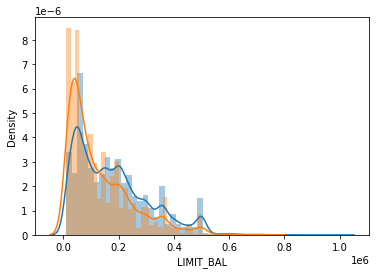

In [17]:
# построим гистограммы со сглаженной кривой распределения
sns.distplot(def_0['LIMIT_BAL'])
sns.distplot(def_1['LIMIT_BAL'])

In [19]:
print ('95%% confidence interval for the mean: [%f, %f]' % zconfint(def_0['LIMIT_BAL']))
print ('95%% confidence interval for the mean: [%f, %f]' % zconfint(def_1['LIMIT_BAL']))

95% confidence interval for the mean: [176411.914497, 179787.537651]
95% confidence interval for the mean: [127333.653340, 132885.659499]


In [20]:
# Интервалы для средних не пересекаются, значит можем отвергнуть гипотезу о равенстве средних.
# Тем не менее, проверим с помощью перестановочного критерия

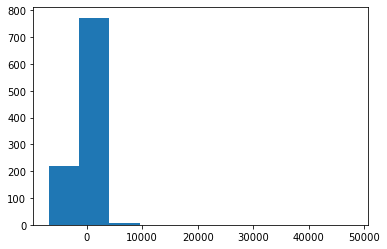

In [22]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

pylab.hist(permutation_zero_dist_ind(def_0['LIMIT_BAL'], def_1['LIMIT_BAL'], max_combinations = 1000))
pylab.show()

In [23]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [25]:
# проверим гипотезу о равенстве распределений, где нулевая гипотеза означает их равенство
print ("p-value: %f" % permutation_test(def_0['LIMIT_BAL'], def_1['LIMIT_BAL'], max_permutations = 1000))

p-value: 0.001000


In [ ]:
# гипотеза о равенстве распределений отвергается

Полученные результаты являются практически значимыми, различия в распределениях видны невооружённым взглядом, а средние значения различаются в 1,4 раза.

# Задание 2

# Способ 1

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [26]:
# разобьём наши подвыборки с default = 0 и default = 1 на мужчин и женщин
# уберём признаки 'SEX', 'default' и 'ID'
male_0 = def_0[data.SEX == 1]
male_0.drop(['SEX', 'default', 'ID'], axis=1, inplace = True)
fem_0 = def_0[data.SEX == 2]
fem_0.drop(['SEX', 'default', 'ID'], axis=1, inplace = True)
male_1 = def_1[data.SEX == 1]
male_1.drop(['SEX', 'default', 'ID'], axis=1, inplace = True)
fem_1 = def_1[data.SEX == 2]
fem_1.drop(['SEX', 'default', 'ID'], axis=1, inplace = True)

<ipython-input-26-22e705005439>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_0 = def_0[data.SEX == 1]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-26-22e705005439>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fem_0 = def_0[data.SEX == 2]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-26-22e705005439>:7: UserWarning: Boolean Series key 

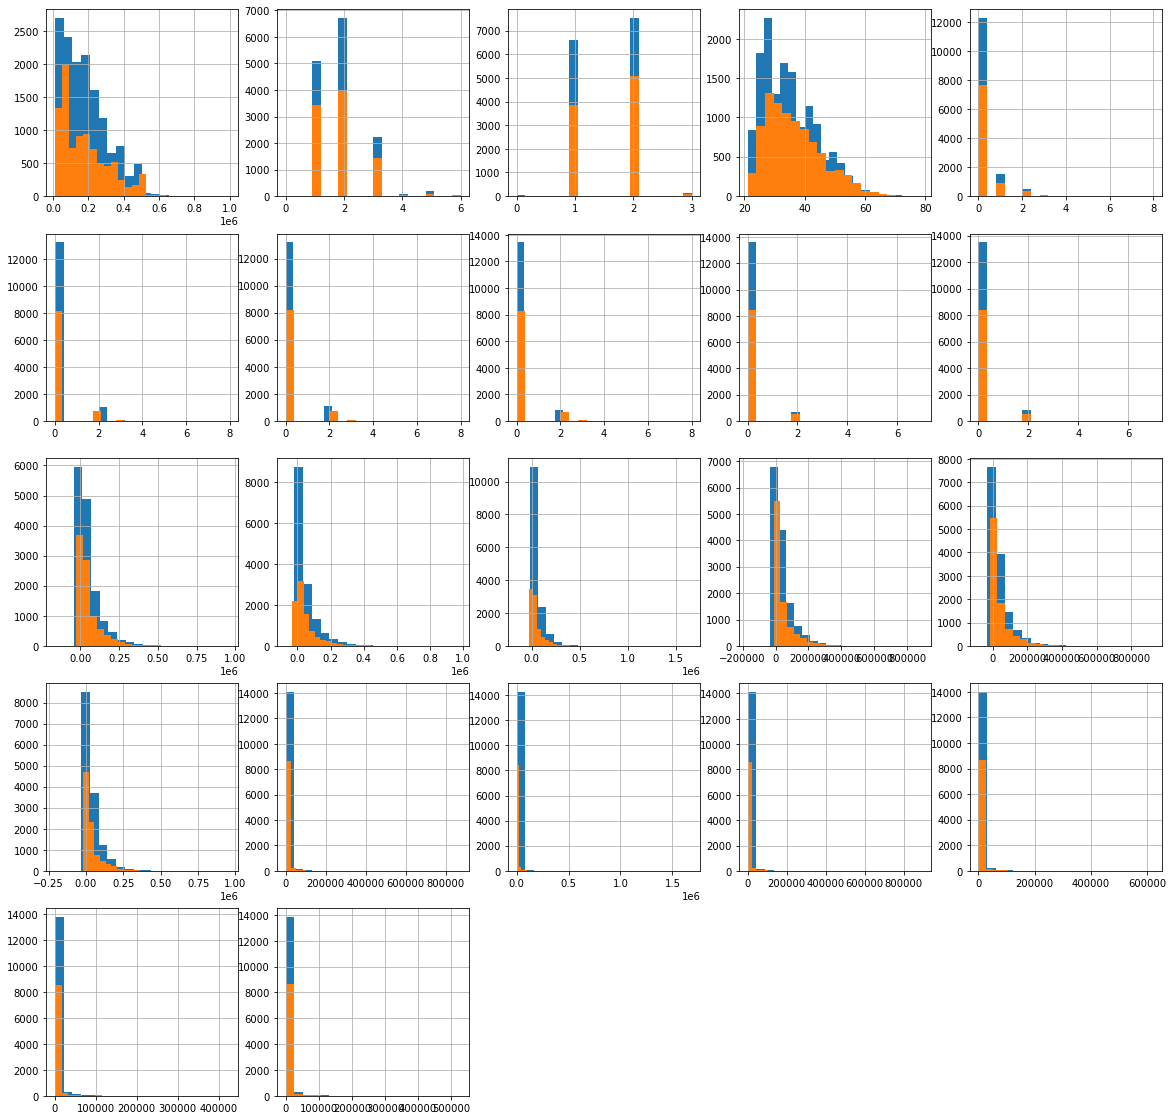

In [27]:
# построим попарно гистограммы для всех признаков у мужчин и женщин с default = 0 
k = 1
for i in fem_0.columns: 
    pylab.subplot(5, 5, k)
    fem_0[i].hist(bins = 20, figsize=(20,20))
    male_0[i].hist(bins = 20, figsize=(20,20))
    k = k + 1

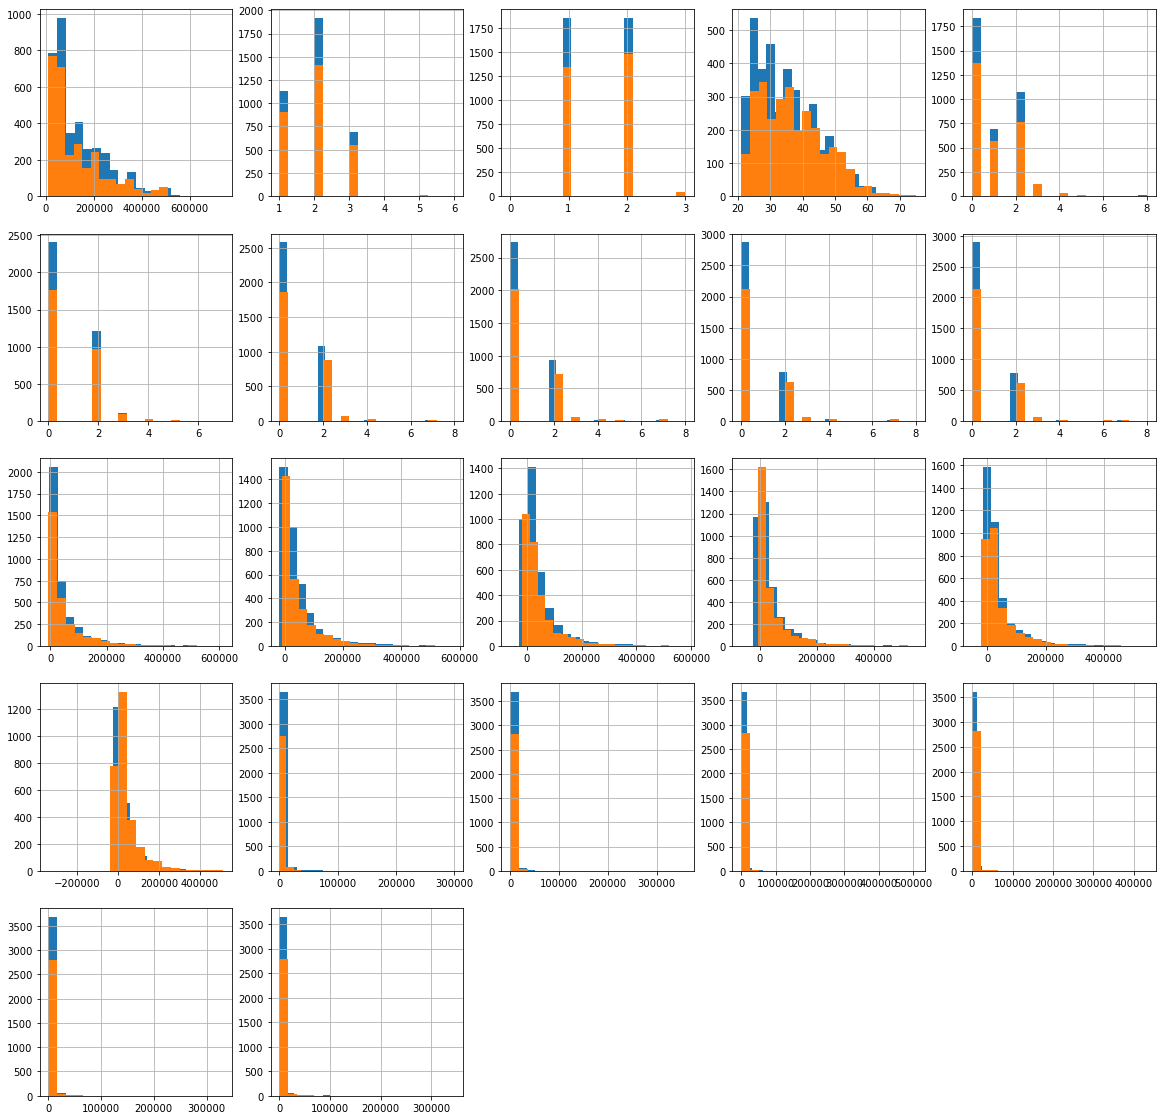

In [28]:
# построим попарно гистограммы для всех признаков у мужчин и женщин с default = 1 
k = 1
for i in fem_1.columns: 
    pylab.subplot(5, 5, k)
    fem_1[i].hist(bins = 20, figsize=(20,20))
    male_1[i].hist(bins = 20, figsize=(20,20))
    k = k + 1

In [29]:
# с помощью тех же перестановок можно проверить гипотезу о том,
# что гендерный состав группы людей вернувших и не вернувших кредит отличается

In [30]:
p_value_1 = list()
for i in fem_0.columns:
    p_value = permutation_test(fem_0[i], male_0[i], max_permutations = 1000)
    p_value_1.append(p_value)

In [134]:
p_value_2 = list()
for i in fem_1.columns:
    p_value = permutation_test(fem_1[i], male_1[i], max_permutations = 1000)
    p_value_2.append(p_value)

In [135]:
# осуществим поправку на множественность гипотез методом Бенджамини-Хохберга

In [136]:
reject_1, p_corrected_1, a11, a12 = smm.multipletests(p_value_1, alpha=0.025, method='fdr_bh')
reject_2, p_corrected_2, a21, a22 = smm.multipletests(p_value_2, alpha=0.025, method='fdr_bh')

In [140]:
# найдём количество значимых отличий в группе
s_1 = 0
for i in range(len(p_corrected_1)):
    if p_corrected_1[i] < 0.025:
        s_1 = s_1 + 1
s_1

14

In [ ]:
# 14 отличий из 22 признаков очень существенно -> разннополые группы с default = 0 различны

In [141]:
s_2 = 0
for i in range(len(p_corrected_2)):
    if p_corrected_2[i] < 0.025:
        s_2 = s_2 + 1
s_2

6

In [194]:
# 6 отличий из 22 признаков менее существенно -> разнополые группы с default = 1 не так сильно различаются, как с default = 0

# Способ 2

In [217]:
# изобразим таблицу значений

male = data[data.SEX == 1]
fem = data[data.SEX == 2]

m0 = len(male_0)
m1 = len(male_1)
f0 = len(fem_0)
f1 = len(fem_1)

sex = {'male': male, 'female': fem}

nums = [[m0, m1], [f0, f1]]

df = pd.DataFrame(nums, index=sex.keys(), columns=['default = 0', 'default = 1'])

df

,default = 0,default = 1
male,9015,2873
female,14349,3763


In [224]:
conf_interval_m = proportion_confint(sum(male['default']), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_f = proportion_confint(sum(fem['default']), 
                                            data.shape[0],
                                            method = 'wilson')

In [226]:
print '95%% confidence interval for male: [%f, %f]' % conf_interval_m
print '95%% confidence interval for female [%f, %f]' % conf_interval_f

95% confidence interval for male: [0.092488, 0.099149]
95% confidence interval for female [0.121733, 0.129229]


In [227]:
# посмотрим по Z критерию для долей

In [228]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [229]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(male['default'], fem['default'])

95% confidence interval for a difference between proportions: [0.024207, 0.043612]


In [230]:
# видим, что интервал смещён правее нуля -> гендерный состав группы людей вернувших и не вернувших кредит отличается.

# Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

In [280]:
# изобразим матрицу сопряжённости  "образование" на "возврат долга"
confusion_mx = pd.crosstab(data.EDUCATION, data.default)
confusion_mx

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [341]:
chi, p, shape, array_chi = chi2_contingency(confusion_mx)

In [282]:
# заполним таблицу разностями между наблюдаемым и ожидаемым количеством человек.

In [308]:
for i in range(7):
         for j in range(2):
             print round(confusion_mx[j][i] - array_chi[i][j]),
         print

3.0 -3.0
305.0 -305.0
-227.0 227.0
-149.0 149.0
20.0 -20.0
44.0 -44.0
3.0 -3.0


In [309]:
# приведём таблицу к одному масштабу, записывая в ячейки доли от общего числа

In [336]:
for i in range(7):
         for j in range(2):
             confusion_mx_prop[j][i] = float(confusion_mx[j][i]) / sum(confusion_mx, axis = 1)[i]      

In [337]:
confusion_mx_prop

default,0,1
EDUCATION,,
0,1.000000,0.000000
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


In [342]:
chi, p, shape, array_chi_prop = chi2_contingency(confusion_mx_prop)

In [345]:
for i in range(7):
         for j in range(2):
             print round(confusion_mx_prop[j][i] - array_chi_prop[i][j], 4),
         print

0.137 -0.137
-0.0553 0.0553
-0.1003 0.1003
-0.1145 0.1145
0.0801 -0.0801
0.0728 -0.0728
-0.0198 0.0198


In [347]:
# можно сделать вывод, что доктора наук отдают долг лучше всего (это было очевидно из того, что ни один доктор наук не имеет дефолта)
# худшим заёмщиком в плане образованности является выпускник школы (максимальный коэффициент) в последней таблице

# Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Посмотрим на пропуски:

In [385]:
marriage_nan = data[data.MARRIAGE == 0] + data[data.MARRIAGE == 3]

In [388]:
float(marriage_nan.shape[0]) / data.shape[0]

0.012566666666666667

Доля объектов с неустановленным семейным положением не превышает 1.3%. Восстановить пропущенные данные не представляется возможным. Значит, данные объекты можно удалить

In [410]:
data_marr_1 = data[data.MARRIAGE == 1]

In [411]:
data_marr_2 = data[data.MARRIAGE == 2]

In [426]:
# посчитаем долю холостых людей с дефолтом
float(sum(data_marr_2['default'])) / len(data_marr_2['default']) 

0.20928338762214985

In [427]:
# посчитаем долю женатых/ замужних людей с дефолтом
float(sum(data_marr_1['default'])) / len(data_marr_1['default']) 

0.23471703638626545

In [429]:
# Доля женатых/ замужних людей с дефолтом выше, чем у холостых. Теперь оценим это статистически
# Воспользуемся коэффициентом Крамера

In [ ]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [448]:
confusion_mx_marr = pd.crosstab(data.MARRIAGE, data.default)
confusion_mx_marr = confusion_mx_marr[1:3][:]
confusion_mx_marr

default,0,1
MARRIAGE,,
1,10453,3206
2,12623,3341


In [449]:
cramers_corrected_stat(confusion_mx_marr)

0.030473764821587788

In [450]:
# Коффициент Крамера получился маленький, значит нет выраженной зависимости между дефолтами и семейным положением заёмщика

# Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [451]:
# разобьём людей на 2 группы: default = 0 и default = 1
def_0 = data[data.default == 0]
def_1 = data[data.default == 1]

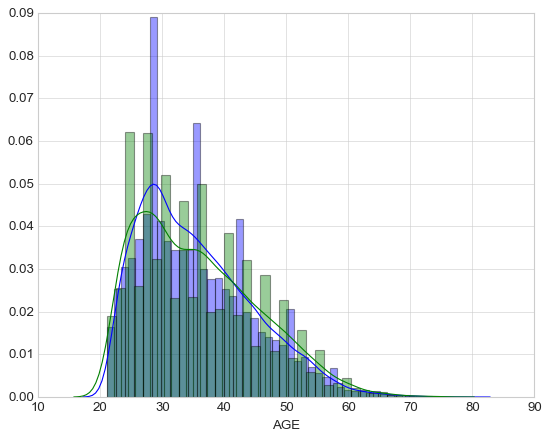

In [464]:
# построим гистограммы со сглаженной кривой распределения
sns.distplot(def_0['AGE'])
sns.distplot(def_1['AGE'])

In [ ]:
# проверим гипотезу о равенстве медиан

In [475]:
print '95%% confidence interval for the mean: [%f, %f]' % zconfint(def_0['AGE'])
print '95%% confidence interval for the mean: [%f, %f]' % zconfint(def_1['AGE'])

95% confidence interval for the mean: [35.300871, 35.533661]
95% confidence interval for the mean: [35.492515, 35.958962]


In [479]:
stats.mannwhitneyu(def_0['AGE'], def_1['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

In [ ]:
# Нельзя отвергать нудевую гипотезу о равенстве медиан

In [455]:
# проверим гипотезу о равенстве распределений с помощью перестановочного критерия

In [456]:
print "p-value: %f" % permutation_test(def_0['AGE'], def_1['AGE'], max_permutations = 1000)

p-value: 0.023000


In [ ]:
# гипотеза о равенстве распределений отвергается на уровне значимости 0.05

In [ ]:
# Тем не менее, влияние данного параметра на дефолт заёмщика оказывает не такое существенное влияние,
# как, например, тот же скоринг из задания 1. 